In [2]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt

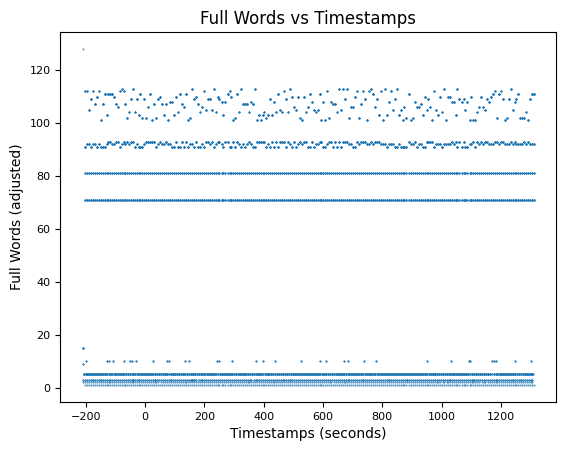

[128  15  15  15  15   9   9   2   3   3   5   5   5   5   5   5   1 112
 112 112  91  91  91  91  91  81  81  81  71  71  71  71   2   3   3   5
   5   5   5  10  10   1 112 112 112  92  92  92  92  81  81  81  71  71
  71  71   2   3   3   5   5   5   5   5   5   1 105 105 105 105  92  92
  92  92  81  81  81  71  71  71  71   2   3   3   5   5   5   5   5   5
   1 109 109 109 109 109  91  91  91  91]
[  1   2   3   5   9  10  15  71  81  91  92  93 101 102 103 104 105 106
 107 108 109 110 111 112 113 128]


In [4]:
# for 20250306

# Load the full_words.npy and timestamps.npy files
full_words = np.load(r"D:\20250313\zarya20250313dots3DMP_ttl.npy")
timestamps = np.load(r"D:\20250313\zarya20250313dots3DMP_ttltimestamps.npy")
ttl_blocks = np.load(r"D:\20250313\zarya20250313dots3DMP_ttlblocks.npy")

full_words[full_words >= 256] -= 256

block_indices = (ttl_blocks >= 0) # include all block! 

# Exclude values that are still >= 256 after subtraction
valid_indices = (full_words > 0) & (full_words != 13)

if np.any(block_indices):
    filtered_full_words = full_words[valid_indices & block_indices]
    filtered_timestamps = timestamps[valid_indices & block_indices]
    filtered_ttl_blocks = ttl_blocks[valid_indices & block_indices]
else:
    filtered_full_words = full_words[valid_indices]
    filtered_timestamps = timestamps[valid_indices]
    filtered_ttl_blocks = ttl_blocks[valid_indices]

# plt.figure(figsize=(6, 4))  
plt.plot(filtered_timestamps, filtered_full_words, '.', markersize=0.8) 
plt.xlabel("Timestamps (seconds)")
plt.ylabel("Full Words (adjusted)")
plt.title("Full Words vs Timestamps")

# Reduce ticks for a cleaner look
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()
print(np.unique(filtered_full_words))

In [5]:
mat_data = scipy.io.loadmat(r'D:\20250306\zarya20250306dots3DMP_info.mat')

info = mat_data['info']

pldaps_filetimes = info['pldaps_filetimes'][0][0]
pldaps_filetimes = pldaps_filetimes.flatten()
par = info['par'][0, 0]

In [18]:
data = filtered_full_words.copy()
timestamps = filtered_timestamps.copy()

# Define event codes 
TRIAL = 1
FIX = 2
FIXATION = 3
STIMONOFF = 5
SACC = 6
TARGHOLD = 7
POSTTARGHOLD = 8
BREAKFIX = 10

# Define BLOCK and event indices
total_blocks = np.unique(filtered_ttl_blocks)
block_type = np.full(filtered_ttl_blocks.shape, '', dtype='O')

for i in total_blocks:
    # Define PDS_filetime and par
    block_indices = np.where(filtered_ttl_blocks == i)[0]
    data_block = data[block_indices[0]:block_indices[-1] + 1]  
    first_fix_idx = np.where(data_block == FIX)[0]
    PDS_filetime = data_block[1] * 100 + (data_block[first_fix_idx[0]-1])   
    matched_idx = np.where(pldaps_filetimes == PDS_filetime)[0]
    if matched_idx.size > 0:
        corresponding_par = par[matched_idx[0]]
        block_type[block_indices[0]:block_indices[-1] + 1] = corresponding_par
        print(f"Matched PDS_filetime: {PDS_filetime}, Corresponding par: {corresponding_par}")
    else:
        print(f"No match found for PDS_filetime: {PDS_filetime}")
        break

# Define TRIAL
trial_indices = np.where(data == TRIAL)[0]
idx_diffs = np.diff(trial_indices) > 10
filtered_indices = np.concatenate(([trial_indices[0]], trial_indices[1:][idx_diffs]))
trial_indices = np.array(filtered_indices)
block_type = block_type[trial_indices]
block_type = np.array([b.strip() for b in block_type])
trial_size = len(trial_indices)

# Define Behavior idx
fix_idx = timestamps[np.where(data == FIX)[0]]
fixation_idx = timestamps[np.where(data == FIXATION)[0]]
stimOn_idx = timestamps[np.where(data == STIMONOFF)[0]]
stimOff_idx = timestamps[np.where(data == STIMONOFF)[-1]]
saccOnset_idx = timestamps[np.where(data == SACC)[0]]
targHold_idx = timestamps[np.where(data == TARGHOLD)[0]]
postTargHold_idx = timestamps[np.where(data == POSTTARGHOLD)[0]]
breakFix_idx = timestamps[np.where(data == BREAKFIX)[0]]

event_data = {
    'fpOn_time': np.full(trial_size, np.nan),
    'fixation_time': np.full(trial_size, np.nan),
    'stimOn_time': np.full(trial_size, np.nan),
    'stimOff_time': np.full(trial_size, np.nan),
    'saccOnset_time': np.full(trial_size, np.nan),
    'targHold_time': np.full(trial_size, np.nan),
    'postTargHold_time': np.full(trial_size, np.nan),
    'breakFix_time': np.full(trial_size, np.nan),
    'good_trial': np.zeros(trial_size),
    'headingInd': np.full(trial_size, np.nan),
    'modality': np.full(trial_size, np.nan),
    'coherenceInd': np.full(trial_size, np.nan),
    'deltaInd': np.full(trial_size, np.nan),
    'choice': np.full(trial_size, np.nan),
    'correct': np.full(trial_size, np.nan),
    'PDW': np.full(trial_size, np.nan)
}

vars_to_process = [
    ('deltaInd', 'PDW'),
    ('coherenceInd', 'correct'),
    ('modality', 'choice'),
    ('headingInd',)
]

for j in range(0, len(trial_indices)):
    current_trial = timestamps[trial_indices[j]]  
    if j == 0: 
        previous_trial = timestamps[0]  
    elif j == len(trial_indices) - 1: 
        previous_trial = timestamps[trial_indices[j-1]]  
    else:   
        previous_trial = timestamps[trial_indices[j-1]] 

    valid_fix_idx = fix_idx[(fix_idx > previous_trial) & (fix_idx < current_trial)]
    valid_fixation_idx = fixation_idx[(fixation_idx > previous_trial) & (fixation_idx < current_trial)]
    valid_stimOn_idx = stimOn_idx[(stimOn_idx > previous_trial) & (stimOn_idx < current_trial)]
    valid_stimOff_idx = stimOff_idx[(stimOff_idx > previous_trial) & (stimOff_idx < current_trial)]
    valid_saccOnset_idx = saccOnset_idx[(saccOnset_idx > previous_trial) & (saccOnset_idx < current_trial)]
    valid_targHold_idx = targHold_idx[(targHold_idx > previous_trial) & (targHold_idx < current_trial)]
    valid_postTargHold_idx = postTargHold_idx[(postTargHold_idx > previous_trial) & (postTargHold_idx < current_trial)]
    valid_breakFix_idx = breakFix_idx[(breakFix_idx > previous_trial) & (breakFix_idx < current_trial)]
    
    event_data['fpOn_time'][j] = valid_fix_idx[0] if valid_fix_idx.size > 0 else np.nan
    event_data['fixation_time'][j] = valid_fixation_idx[0] if valid_fixation_idx.size > 0 else np.nan
    event_data['stimOn_time'][j] = valid_stimOn_idx[0] if valid_stimOn_idx.size > 0 else np.nan
    event_data['stimOff_time'][j] = valid_stimOff_idx[0] if valid_stimOff_idx.size > 0 else np.nan
    event_data['saccOnset_time'][j] = valid_saccOnset_idx[0] if valid_saccOnset_idx.size > 0 else np.nan
    event_data['targHold_time'][j] = valid_targHold_idx[0] if valid_targHold_idx.size > 0 else np.nan
    event_data['postTargHold_time'][j] = valid_postTargHold_idx[0] if valid_postTargHold_idx.size > 0 else np.nan
    event_data['breakFix_time'][j] = valid_breakFix_idx[0] if valid_breakFix_idx.size > 0 else np.nan

    if np.isnan(event_data['breakFix_time'][j]):
        event_data['good_trial'][j] = 1 
    if np.isnan(event_data['fixation_time'][j]):
        event_data['good_trial'][j] = 0 
    
    if j == len(trial_indices) - 1:
        event_info = data[trial_indices[j]:]
    else:
        event_info = data[trial_indices[j]:trial_indices[j+1]]
        
    event_idx = event_info >=50
    event_info = event_info[event_idx]
    event_info -= 70
    
    for idx, (var1, *var2) in enumerate(vars_to_process):
        if idx > 0:
            event_info -= 10
        if "headingInd" in var1 or any("headingInd" in v for v in var2):
            new_idx = (event_info <= 20) & (event_info >= 0)
        else:
            new_idx = (event_info <= 10) & (event_info >= 0)
        new_info = event_info[new_idx]

        if new_info.size > 0:
            event_data[var1][j] = new_info[0] 
            print(var1, new_info[0] )
            if var2:
                event_data[var2[0]][j] = new_info[-1]
                
                if event_data['breakFix_time'][j] == 0:
                    event_data[var2[0]][j] = np.nan
        else:
            event_data[var1][j] = np.nan
            if var2:
                event_data[var2[0]][j] = np.nan


Matched PDS_filetime: 1509.0, Corresponding par: dots3DMP      
[  1 112 112 112  91  91  91  91  91  81  81  81  71  71  71  71   2   3
   3   5   5   5   5  10  10]
[('deltaInd', 'PDW'), ('coherenceInd', 'correct'), ('modality', 'choice'), ('headingInd',)]
deltaInd 1
coherenceInd 1
modality 1
headingInd 12
[  1 112 112 112  92  92  92  92  81  81  81  71  71  71  71   2   3   3
   5   5   5   5   5   5]
[('deltaInd', 'PDW'), ('coherenceInd', 'correct'), ('modality', 'choice'), ('headingInd',)]
deltaInd 1
coherenceInd 1
modality 2
headingInd 12
[  1 105 105 105 105  92  92  92  92  81  81  81  71  71  71  71   2   3
   3   5   5   5   5   5   5]
[('deltaInd', 'PDW'), ('coherenceInd', 'correct'), ('modality', 'choice'), ('headingInd',)]
deltaInd 1
coherenceInd 1
modality 2
headingInd 5
[  1 109 109 109 109 109  91  91  91  91  91  81  81  81  71  71  71  71
   2   3   3   5   5   5   5   5   5]
[('deltaInd', 'PDW'), ('coherenceInd', 'correct'), ('modality', 'choice'), ('headingInd',)]


In [11]:
par_type = ['dots3DMP', 'dots3DMPtuning']
save_path = r'D:\20250306\zarya20250306dots3DMP.mat'

data = {}

for i in range(len(par_type)):
    trial_2_save = block_type == par_type[i]
    
    trial_data = {}
    for key in event_data:
        if par_type[i] == 'dots3DMPtuning' and key in ['choice', 'correct', 'PDW']:
            continue
        trial_data[key] = event_data[key][trial_2_save]
    
    data[f'{par_type[i]}'] = {'events': trial_data}

scipy.io.savemat(save_path, {'data': data})

print(f"Data saved at '{save_path}' ")


Data saved at 'D:\20250306\zarya20250306dots3DMP.mat' 
